# Lets make an interactive web application from scratch

First we have to import some dependencies 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import sys

sys.path.append("..")
import urbanpy as up
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
tqdm.pandas()

## Downloading urban data

This notebook is going to use the Manta, Ecuador as an example. Now we are going to download the city administrative limits.

In [4]:
manta = up.download.nominatim_osm("Manta, Ecuador")

<Axes: >

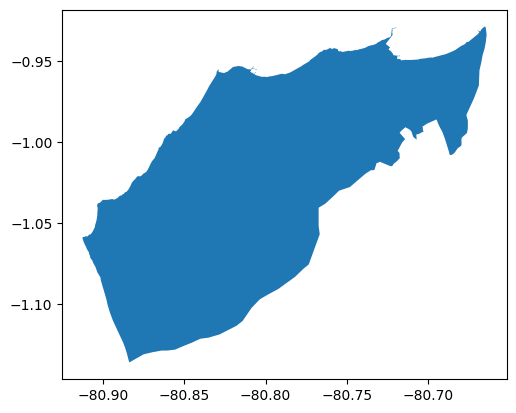

In [5]:
manta.plot()

It is useful to have a uniform spatial unit in order to apply algorithms and visualize differents cities data. UrbanPy lets your easily leverage all the power of Uber H3 package to partition the city in uniform hexagons.

In [6]:
hex_manta = up.geom.gen_hexagons(resolution=9, city=manta)

In [7]:
hex_manta.head()

,hex,geometry
0,898f2e05843ffff,"POLYGON ((-80.67290 -0.97060, -80.67405 -0.972..."
1,898f2e0decfffff,"POLYGON ((-80.84067 -1.01740, -80.84182 -1.018..."
2,898f2e7664bffff,"POLYGON ((-80.81134 -1.07478, -80.81249 -1.076..."
3,898f2e0426bffff,"POLYGON ((-80.66586 -0.93258, -80.66701 -0.934..."
4,898f2e0c0b7ffff,"POLYGON ((-80.77717 -0.97733, -80.77832 -0.978..."


In [8]:
# Number of resolution 9 hexagons in Manta
hex_manta.shape

(2416, 2)

Which area $km^2$ does each hexagon cover?

In [9]:
hex_area = (
    hex_manta.to_crs(
        epsg=32717
    ).geometry.area  # Project to meters  # Get the area of the first hexagon
    / 10**6
)  # Convert to km2

print(f"Hexagon area: ~{hex_area.mean():.4f} km2")

Hexagon area: ~0.1214 km2


<Axes: >

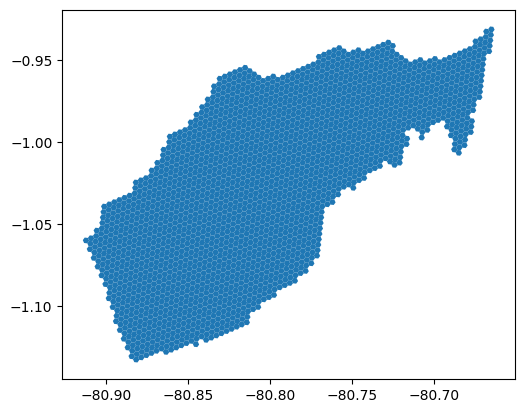

In [10]:
hex_manta.plot()

### Downloading high resolution population data

Using the `download.search_hdx_dataset` and `download.get_hdx_dataset` functions you can download high resolution population data, please be patient this may take a while ...

In [11]:
ecu_resources_df = up.download.search_hdx_dataset("ecuador")
ecu_resources_df

,created,name,population,size_mb,url
id,,,,,
0,2019-06-11,ecu_general_2020_csv.zip,Overall population density,15.08,https://data.humdata.org/dataset/58c3ac3f-febd...
2,2019-06-11,ecu_children_under_five_2020_csv.zip,Children (ages 0-5),15.00,https://data.humdata.org/dataset/58c3ac3f-febd...
4,2019-06-11,ecu_elderly_60_plus_2020_csv.zip,Elderly (ages 60+),14.98,https://data.humdata.org/dataset/58c3ac3f-febd...
6,2019-06-11,ecu_men_2020_csv.zip,Men,15.03,https://data.humdata.org/dataset/58c3ac3f-febd...
8,2019-06-11,ecu_women_2020_csv.zip,Women,15.03,https://data.humdata.org/dataset/58c3ac3f-febd...
10,2019-06-11,ecu_women_of_reproductive_age_15_49_2020_csv.zip,Women of reproductive age (ages 15-49),15.02,https://data.humdata.org/dataset/58c3ac3f-febd...
12,2019-06-11,ecu_youth_15_24_2020_csv.zip,Youth (ages 15-24),15.01,https://data.humdata.org/dataset/58c3ac3f-febd...


In [12]:
ecu_elderly_pop = up.download.get_hdx_dataset(ecu_resources_df, 4)

In [13]:
manta_elderly_pop = up.geom.filter_population(ecu_elderly_pop, manta)

In [14]:
manta_elderly_pop.head()

,longitude,latitude,ecu_elderly_60_plus_2020,geometry
1306998,-80.664861,-0.929028,0.606377,POINT (-80.66486 -0.92903)
1306999,-80.664583,-0.929028,0.606377,POINT (-80.66458 -0.92903)
1307000,-80.664306,-0.929028,0.606377,POINT (-80.66431 -0.92903)
1307001,-80.664028,-0.929028,0.606377,POINT (-80.66403 -0.92903)
1307320,-80.664583,-0.929306,0.606377,POINT (-80.66458 -0.92931)


### Unify data layers

Lets get the population per hexagon

In [15]:
hex_manta_gdf = up.geom.merge_shape_hex(
    hex_manta, manta_elderly_pop, agg={"ecu_elderly_60_plus_2020": "sum"}
)

In [16]:
hex_manta_gdf.head()

,hex,geometry,ecu_elderly_60_plus_2020
0,898f2e05843ffff,"POLYGON ((-80.67290 -0.97060, -80.67405 -0.972...",15.718020
1,898f2e0decfffff,"POLYGON ((-80.84067 -1.01740, -80.84182 -1.018...",NaN
2,898f2e7664bffff,"POLYGON ((-80.81134 -1.07478, -80.81249 -1.076...",NaN
3,898f2e0426bffff,"POLYGON ((-80.66586 -0.93258, -80.66701 -0.934...",1.212754
4,898f2e0c0b7ffff,"POLYGON ((-80.77717 -0.97733, -80.77832 -0.978...",NaN


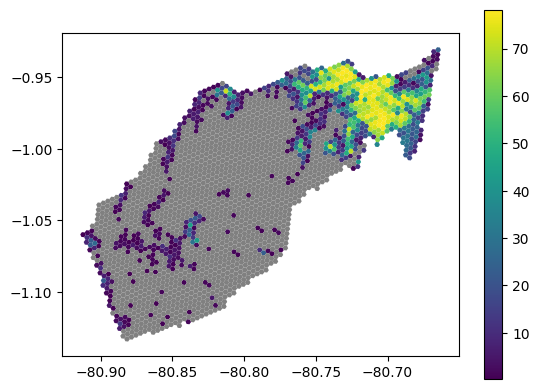

In [17]:
hex_manta_gdf.plot(
    column="ecu_elderly_60_plus_2020", legend=True, missing_kwds={"color": "grey"}
)
plt.show()

**Validation**: The difference between original population total and downscaled population total must be a small number

In [18]:
diff = (
    manta_elderly_pop["ecu_elderly_60_plus_2020"].sum()
    - hex_manta_gdf["ecu_elderly_60_plus_2020"].sum()
)

(
    manta_elderly_pop["ecu_elderly_60_plus_2020"].sum().round(0),
    hex_manta_gdf["ecu_elderly_60_plus_2020"].sum().round(0),
    diff.round(0),
)

(24622.0, 21256.0, 3366.0)

## Downloading Points of Interest (PoI) data

### Health facilities

In [19]:
health_facilities = up.download.overpass_pois(
    bounds=manta.total_bounds, facilities="health"
)

In [20]:
health_facilities.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,367826732,-0.944024,-80.733939,"{'amenity': 'pharmacy', 'brand': 'Fybeca', 'br...",POINT (-80.73394 -0.94402),pharmacy
1,node,3206491590,-1.040708,-80.665107,"{'amenity': 'hospital', 'name': 'Clínica Monte...",POINT (-80.66511 -1.04071),hospital
2,node,4122103989,-0.970592,-80.702927,"{'addr:street': 'Avenida 4 de Noviembre', 'ame...",POINT (-80.70293 -0.97059),clinic
3,node,4174658616,-0.947050,-80.722142,"{'amenity': 'pharmacy', 'brand': 'Fybeca', 'br...",POINT (-80.72214 -0.94705),pharmacy
4,node,4253791990,-0.980949,-80.699016,"{'amenity': 'dentist', 'healthcare': 'dentist'...",POINT (-80.69902 -0.98095),dentist


In [21]:
health_facilities["poi_type"].value_counts()

poi_type
pharmacy    34
hospital     8
clinic       7
doctors      4
dentist      1
Name: count, dtype: int64

### Measuring accesibility

#### Accesibility to hospital and clinics

In [22]:
clinics_and_hospitals = health_facilities[
    health_facilities["poi_type"].isin(["clinic", "hospital"])
]

In [23]:
# start local routing server
up.routing.start_osrm_server("ecuador", "south-america", "foot")

Starting server ...
osrm_routing_server_south-america_ecuador_foot
Server was started succesfully


Now we are going to find the route distance and duration using an OSRM local server. To find the nearest food facility to each hexagon this function use a neighborhood search algorithm (lower precision but significant time savings)

In [24]:
hex_manta_gdf_access = up.accessibility.travel_times(
    hex_manta_gdf, clinics_and_hospitals, "health_facility"
)

  0%|          | 0/2416 [00:00<?, ?it/s]

In [25]:
hex_manta_gdf_access.head()

,hex,geometry,ecu_elderly_60_plus_2020,lon,lat,nearest_health_facility_ix,distance_to_nearest_health_facility,duration_to_nearest_health_facility,duration_to_nearest_health_facility_label
0,898f2e05843ffff,"POLYGON ((-80.67290 -0.97060, -80.67405 -0.972...",15.718020,-80.672100,-0.972374,9,2.4804,29.771667,De 15 a 30
1,898f2e0decfffff,"POLYGON ((-80.84067 -1.01740, -80.84182 -1.018...",NaN,-80.839874,-1.019183,13,7.5701,90.830000,De 90 a 120
2,898f2e7664bffff,"POLYGON ((-80.81134 -1.07478, -80.81249 -1.076...",NaN,-80.810543,-1.076555,13,14.7739,177.275000,Más de 120
3,898f2e0426bffff,"POLYGON ((-80.66586 -0.93258, -80.66701 -0.934...",1.212754,-80.665061,-0.934356,8,4.9953,59.948333,De 45 a 60
4,898f2e0c0b7ffff,"POLYGON ((-80.77717 -0.97733, -80.77832 -0.978...",NaN,-80.776372,-0.979112,4,6.4528,77.568333,De 60 a 90


In [26]:
up.routing.stop_osrm_server("ecuador", "south-america", "foot")

Server was stoped succesfully


Visualize results

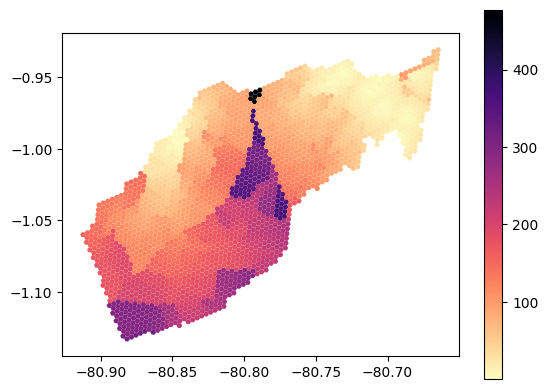

In [27]:
hex_manta_gdf_access.plot(
    "duration_to_nearest_health_facility",
    cmap="magma_r",
    legend=True,
    missing_kwds={"color": "grey"},
)
plt.show()

# Using Dash to create an interactive webapp

Import Dash dependencies

> Install Dash before running the following cells: `pip install dash jupyter-dash`

In [28]:
from dash import dcc, html
from dash.dependencies import Input, Output

In this example we are using JupyterDash to show our webapp within jupyter lab or a notebook.

In [29]:
from jupyter_dash import JupyterDash

In [30]:
app = JupyterDash(name="UrbanPy Dashboard")

In [31]:
VARIABLE_OPTIONS = [
    {"label": "Duración del viaje", "value": "duration_to_nearest_health_facility"},
    {"label": "Población mayor de 60", "value": "ecu_elderly_60_plus_2020"},
]

In [32]:
app.layout = html.Div(
    [
        html.H3(
            "Análisis de Acceso a Establecimientos de Salud para Población Mayor (>60 años) en Manta, Ecuador"
        ),
        dcc.Dropdown(
            id="variable", value="ecu_elderly_60_plus_2020", options=VARIABLE_OPTIONS
        ),
        dcc.Graph(id="map"),
    ]
)

In [33]:
@app.callback(Output("map", "figure"), [Input("variable", "value")])
def update_map(var):
    # Filter hexagons with 0 population
    hex_pop_filtered = hex_manta_gdf_access.query("ecu_elderly_60_plus_2020 > 0")
    # Reset index to avoid issues with plotly
    hex_pop_filtered = hex_pop_filtered.reset_index(drop=True)
    # Return the choropleth map
    return up.plotting.choropleth_map(
        gdf=hex_pop_filtered, color_column=var, zoom=10, opacity=0.5
    )

In [34]:
app.run_server(mode="inline")

Dash is running on http://127.0.0.1:8050/



Thanks for viewing this example notebook. You can find the urbanpy documentation [here](https://ingenieriaup.github.io/urbanpy/).

Useful resources:

1. [Dash Getting Started](https://dash.plotly.com/layout)
2. [Dash Make your Webapp publicly available](https://dash.plotly.com/deployment)